SCANPY is a scalable toolkit for analyzing single-cell gene expression data. It includes methods for preprocessing, visualization, clustering, pseudotime and trajectory inference, differential expression testing, and simulation of gene regulatory networks. 

Make sure you've installed Scanpy:

In [1]:
%conda install -c conda-forge scanpy python-igraph leidenalg

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

In [17]:
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/paulinampaiz/opt/anaconda3/envs/deepchem/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

: 

In [5]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2022-07-20 15:59:17--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2022-07-20 15:59:18--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  40.0MB/s    in 0.2s    

2022-07-20 15:59:18 (40.0 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991

In [5]:
results_file = 'write/pbmc3k.h5ad' # the file that will store the analysis results

In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


See [anndata-tutorials/getting-started] for a more comprehensive introduction to AnnData.

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

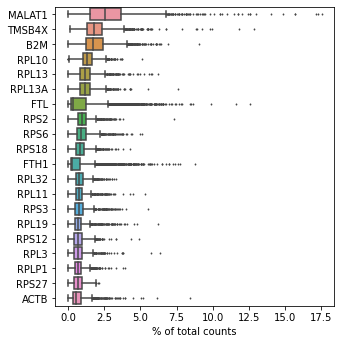

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [ ]:
Basic filtering:

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

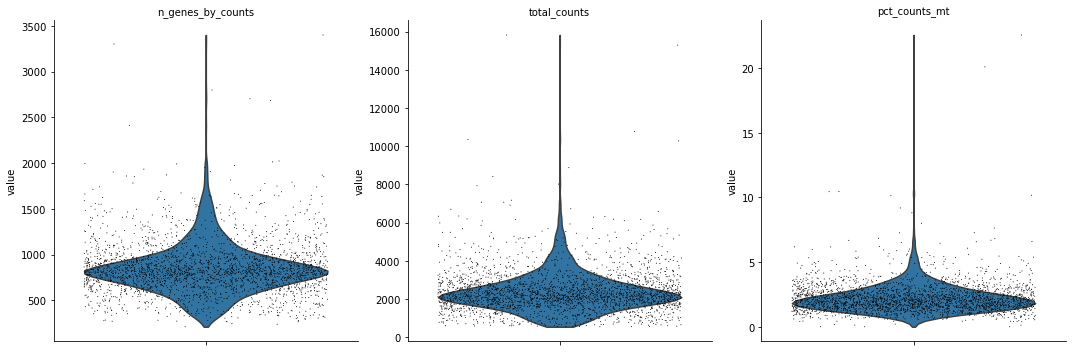

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

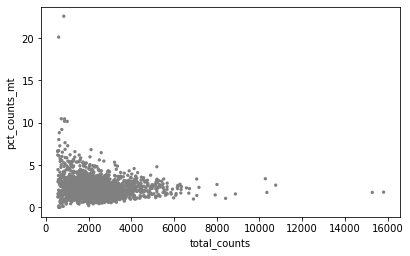

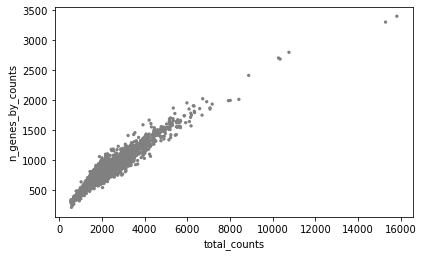

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
Actually do the filtering by slicing the AnnData object.

In [4]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

NameError: name 'adata' is not defined